##### Flow:
1. load, reshape and split in test and train all the images
2. instantiate a cnn model 
3. run the model on train and test data to verify how many epochs are more or less needed to get a nice model
4. use that number of epochs to run cross validation (pass the whole 'set_' of images to the cross validation). Repeat from 2 with another model and compare.


- If you notice that you hardly overfit maybe remove/decrease the dropout layers (e.g. from 0.25 to 0.15)
- Try building a model that predicts directly 16x16

In [1]:
%matplotlib inline

import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.6
set_session(tf.Session(config=config))

import matplotlib.pyplot as plt
from datetime import datetime

# keras functions
from keras import callbacks
from keras import preprocessing
from keras.preprocessing import image

# our libraries
from preprocessing import *

from cnn_models import *
from evaluate import *

import scipy as scipy
from mask_to_submission import *

%load_ext autoreload
%autoreload 2

Using TensorFlow backend.


#### Overview
The goal here is to use the CNN to reduce the size of the input image to obtain a "discretized" image of shape, e.g. (W/16, H/16). Every entry of this image is related to a patch in the input image. This obtained image is compared by the CNN with the groundtruth (after properly discretizing by it patch-wise).

### - Load data

In [2]:
# Loaded a set of images
n = 100

imgs, gt_imgs = load_images(n)
imgs[0].shape, gt_imgs[0].shape

Loading 100 images


((400, 400, 3), (400, 400))

### - Reshape the data
We reshape each input to fulfill our cnn inputs and output shape.

In [3]:
# !!! set predict_patch_width in accordance to the model you are using !!!
# the shape of the output of the model depends on the strides parameters 
# (if a layer has stride=2 then each ouput's side is half of the input'side).
# predict_patch_width must be equal to the total reduction of the model, e.g.
# if the model has three layer with stride=2 => the input of the model is 
# reduced by a factor of 2*2*2=8, i.e. the ouptut will be patch-wise with 
# patches 8x8 pixels.
predict_patch_width = 8

X, Y = images_to_XY(imgs, gt_imgs, predict_patch_width=predict_patch_width)

set_ = SimpleNamespace()
set_.X = X
set_.Y = Y

X.shape, Y.shape

((100, 400, 400, 3), (100, 50, 50))

In [4]:
test_ratio = 0.2

train, test = split_train_test(X, Y, test_ratio=test_ratio, seed=1)
train.X.shape, train.Y.shape, test.X.shape, test.Y.shape 

((80, 400, 400, 3), (80, 50, 50), (20, 400, 400, 3), (20, 50, 50))

## multiple models testing

In [5]:
folder_name = "model_"+str('{0:%Y-%m-%d_%H%M%S}'.format(datetime.now()))


model_relu_maxpooling
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_122 (Conv2D)          (None, None, None, 64)    9472      
_________________________________________________________________
max_pooling2d_40 (MaxPooling (None, None, None, 64)    0         
_________________________________________________________________
dropout_77 (Dropout)         (None, None, None, 64)    0         
_________________________________________________________________
conv2d_123 (Conv2D)          (None, None, None, 128)   204928    
_________________________________________________________________
max_pooling2d_41 (MaxPooling (None, None, None, 128)   0         
_________________________________________________________________
dropout_78 (Dropout)         (None, None, None, 128)   0         
_________________________________________________________________
conv2d_124 (Conv2D)          (None, None, None, 128)  

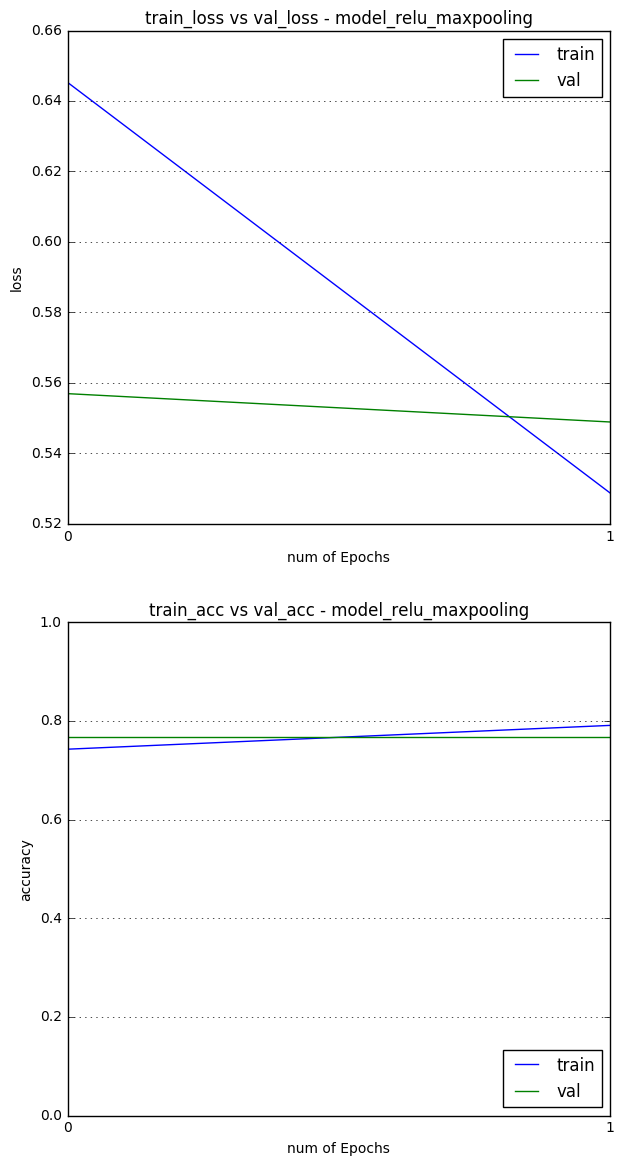

In [19]:
from cnn_models import *
#models = [
#0          model1,
#1          model2,
#2          additional_conv_layer_model,
#3          max_pooling_model,
#4          leaky_relu_model,
#5          decreased_dropout_model,
#6          many_filters_model, 
#7          model_leakyrelu_maxpooling, 
#8          model_relu_maxpooling] 
models_to_train =  [8]
set_ = test
batch_sizes =[4,4,4,4,4,4,4,4,4]
for i in models_to_train:
    # generate an unique name for the model (so to avoid overwriting previous models)
    model_path = "..\\models\\"+folder_name
    model = CnnModel(model_n=i, model_path=model_path)
    model.summary()
    num_epochs=2
    batch_size=batch_sizes[i]
    _ = model.train(train, test=test, num_epochs=num_epochs, batch_size=batch_size, monitor='val_loss') 
    model.save()
    model.plot_history()


### - Others

In [ ]:
# some callbacks example: 

# create a list of callbacks we want to use during training
# # a callback to store epoch results to a csv file
# filename='model_train_new.csv'
# csv_log = callbacks.CSVLogger(filename, separator=',', append=False)

# # a callback to stob before doing the predefined number of epochs (stop before overfitting the data)
# early_stopping = callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=0, verbose=0, mode='min')

# # a callback to save the best model (best model = the one with the lowest 'monitor' variable)
# filepath = "best-weights-{epoch:03d}-{loss:.4f}-{acc:.4f}.hdf5"
# checkpoint = callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

# # callbacks_list = [csv_log,early_stopping,checkpoint]

print(
    "-get configurations:", "\n",
    model.get_config(), "\n",
    model.layers[0].get_config(), "\n",

    "\n-get shapes", "\n",
    model.layers[0].input_shape, "\n",
    model.layers[0].output_shape, "\n",
    
    "\n-get weights", "\n",
    model.layers[0].get_weights()[0].shape, "\n",
    
    "\n-check if trainable", "\n",
    model.layers[0].trainable, "\n", # you can set this to false to "freeze" a layer
)

In [ ]:
from IPython.core.debugger import Pdb
debugger = Pdb()
debugger.set_trace() # put this line as a breakpoint

Test batch generation

In [ ]:
gen1, gen2 = image_generators(X, Y) 

In [ ]:
from cnn_models import batches_generator
j = 0
x_batches = []
y_batches = []

for x, y in batches_generator(X[:4], Y[:4], batch_size = 4):
    j += 1
    if j > 10:
        break
    x_batches.append(x)
    y_batches.append(y)

In [ ]:
np.array(x_batches).shape, np.array(y_batches).shape

In [ ]:
b = 0
i = -1

In [ ]:
i += 1
if i >= x_batches[0].shape[0]:
    i = 0
    b += 1
print("Batch", str(b) + ". Image", i)
fig, axs = plt.subplots(1, 2)
fig.set_size_inches((20, 10))
axs[0].imshow(x_batches[b][i], cmap='gray')
axs[1].imshow(y_batches[b][i][:, :, 1], cmap='gray')